<a target="_blank" href="https://colab.research.google.com/github/raghavbali/mastering_llms_workshop/blob/main/docs/module_04_llm_apps/03_mcp_getting_started.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Tool Calling & MCP 

<img src="../assets/04_tool_calling.png">

> Source: Generated with ❤️ Gemini 2.5 Flash

## Tool Calling

Tool calling, or function calling, is a feature that allows LLMs to interact with external systems. Rather than just generating text, an LLM can be given a list of tools (like APIs or functions) it can use.

### How Does Tool Calling Work?
When a user provides a prompt, the LLM determines if a tool is needed. If so, it outputs a structured request (like a JSON object) detailing which tool to call and with what arguments. A separate program then executes this tool and returns the result to the LLM. The LLM uses this real-time information to formulate a more accurate and comprehensive final response, effectively extending its capabilities beyond its training data.

In [1]:
def add_two_numbers(a: int, b: int) -> int:
  """
  Add two numbers

  Args:
    a: The first integer number
    b: The second integer number

  Returns:
    int: The sum of the two numbers
  """
  return a + b

In [7]:
import ollama

response = ollama.chat(
  'llama3.1',
  messages=[{'role': 'user', 'content': 'What is two plus three? '}],
  tools=[add_two_numbers], # Actual function reference
)

In [8]:
available_functions = {
  'add_two_numbers': add_two_numbers,
}
for tool in response.message.tool_calls or []:
  function_to_call = available_functions.get(tool.function.name)
  if function_to_call:
    print('Function output:', function_to_call(**tool.function.arguments))
  else:
    print('Function not found:', tool.function.name)

Function output: 23


In [9]:
response

ChatResponse(model='llama3.1', created_at='2025-08-22T14:38:54.131935Z', done=True, done_reason='stop', total_duration=1089585583, load_duration=42413208, prompt_eval_count=167, prompt_eval_duration=204462250, eval_count=24, eval_duration=842141875, message=Message(role='assistant', content='', thinking=None, images=None, tool_calls=[ToolCall(function=Function(name='add_two_numbers', arguments={'a': '2', 'b': '3'}))]))

## Model Context Protocol (MCP) 

<img src="../assets/04_llm_mcp.png">

> Source: Generated with ❤️ Gemini 2.5 Flash

### Why MCP
LLMs are powerful but limited to their training data and can't interact with external systems, databases, or real-time information. MCP servers bridge this gap by providing secure, standardized connections between LLMs and external resources.

### What is MCP?
An **MCP (Model Context Protocol)** server is a lightweight service that exposes specific capabilities—like database queries, API calls, file operations, or tool integrations—to LLMs through a standardized protocol. It acts as a secure intermediary that allows AI models to access and interact with external systems while maintaining proper authentication and access controls.

> Think of MCP like a USB-C port for AI applications


<img src="../assets/04_mcp.png">

> Source: [IBM](https://www.ibm.com/think/topics/model-context-protocol)

In [3]:
# !pip3 install fastmcp==2.11.0

In [10]:
import fastmcp

In [11]:
fastmcp.__version__

'2.11.0'

In [5]:
?os.chdir

Signature: os.chdir(path)
Docstring:
Change the current working directory to the specified path.

path may always be specified as a string.
On some platforms, path may also be specified as an open file descriptor.
  If this functionality is unavailable, using it raises an exception.
Type:      builtin_function_or_method

### MCP Server

In [34]:
%%writefile notebook_server.py

import os
import json
from fastmcp import FastMCP
from scraper_utils import NB_Markdown_Scraper

mcp = FastMCP(
    name="Notebook Server",
    instructions="""
        This server provides a markdown scraper utility
        and a tool to write JSON file
        """,)

class NotebookServer():
    def __init__(self,mcp_instance):
        self.start_dir = "/Users/raghavbali/Documents/raghav/work/github/mastering_llms_workshop/docs/"
        input_path=[f'{self.start_dir}{d}' for d in os.listdir(self.start_dir) if d.startswith("module")]
        self.notebook_scraper = NB_Markdown_Scraper(input_path)
        
        # Register methods  
        mcp_instance.tool(self.greet)
        mcp_instance.tool(self.get_notebook_list)
        mcp_instance.tool(self.get_markdown_from_notebook)
        mcp_instance.tool(self.notebook_scraper.scrape_markdowns)
        mcp_instance.tool(self.write_json)
        mcp_instance.tool(self.get_start_dir_directory)
        mcp_instance.resource("resource://data")(self.resource_method)

    def greet(self,name: str= None):
        '''Greets the User'''
        if not name:
            return "Hi, I am NotebookServer"
        else:
            return f"Hi {name}, I am NotebookServer"

    def get_start_dir_directory(self):
        '''Returns the current working directory for the server'''
        return self.start_dir

    def get_notebook_list(self):
        '''Returns List of Notebooks Scraped'''
        return list(self.notebook_scraper.notebook_md_dict.keys())

    def get_markdown_from_notebook(self,notebook_name):
        '''Returns Markdown Cells for specified notebook'''
        if notebook_name in list(self.notebook_scraper.notebook_md_dict.keys()):
            return self.notebook_scraper.notebook_md_dict[notebook_name]
        else:
            return f"Requested notebook ({notebook_name}) does not exist"
        
    def write_json(self,file_name: str):
        '''Tool to write a json file in the format notebook:markdown content'''
        try:
            with open(f"./{file_name}", "w") as record_file:
                json.dump(self.notebook_scraper.notebook_md_dict,record_file)
            return f"File:{file_name} written successfully"
        except Exception as ex:
            return f"Could not write {file_name} due to {ex}"
        
    
    def resource_method(self):
        return """
        Resources provide read-only access to data for the LLM or client application. When a client requests a resource URI:
            + FastMCP finds the corresponding resource definition.
            + If it’s dynamic (defined by a function), the function is executed.
            + The content (text, JSON, binary data) is returned to the client.
        This allows LLMs to access files, database content, configuration, or dynamically generated information relevant to the conversation.
        """

# The methods are automatically registered when creating the instance
provider = NotebookServer(mcp)

if __name__ == "__main__":
    # Initialize and run the server
    mcp.run(transport='stdio')

Overwriting notebook_server.py


### MCP Client

In [ ]:
%%writefile dummy_client.py
import asyncio
from fastmcp import Client, FastMCP

# In-memory server (ideal for testing)
server = FastMCP("TestServer")
client = Client(server)

# HTTP server
client = Client("https://example.com/mcp")

# Local Python script
client = Client("notebook_server.py")

async def main():
    async with client:
        # Basic server interaction
        await client.ping()
        
        # List available operations
        tools = await client.list_tools()
        resources = await client.list_resources()
        prompts = await client.list_prompts()
        
        print("-"*30)
        print("Tools:")
        print("-"*30)
        print(tools)
        print("-"*30)
        print("Resources:")
        print("-"*30)
        print(resources)
        print("-"*30)
        print("Prompts:")
        print(prompts)
        print("-"*30)
        # Execute operations
        await client.call_tool("scrape_markdowns", {})
        result = await client.call_tool("write_json", {"file_name":"test_mcp_server.json"})
        print("-"*30)
        print(f"Result of tool call for write_json:\n{result}")

asyncio.run(main())

> Go to terminal and from the module 4's directory execute : ``>python3 dummy_client.py``

The following should be the output on your screen
<img src="../assets/04_mcp_client.png">

## Demo with Claude App

### Update Claude MCP Server Config

#### Open Settings
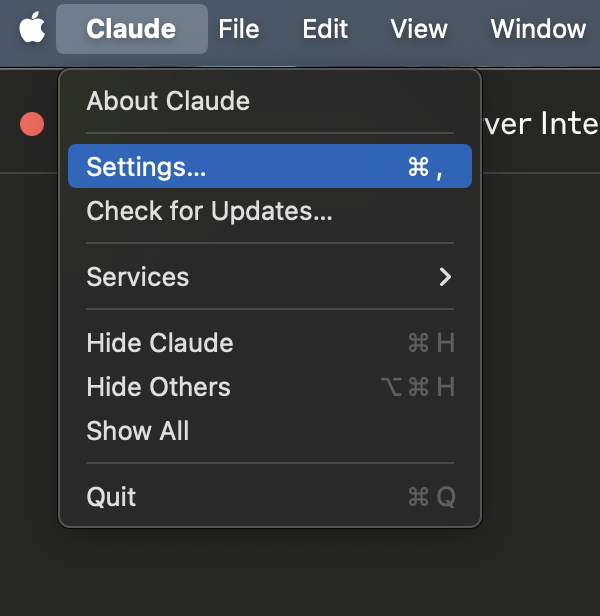


#### Go to Developer Options
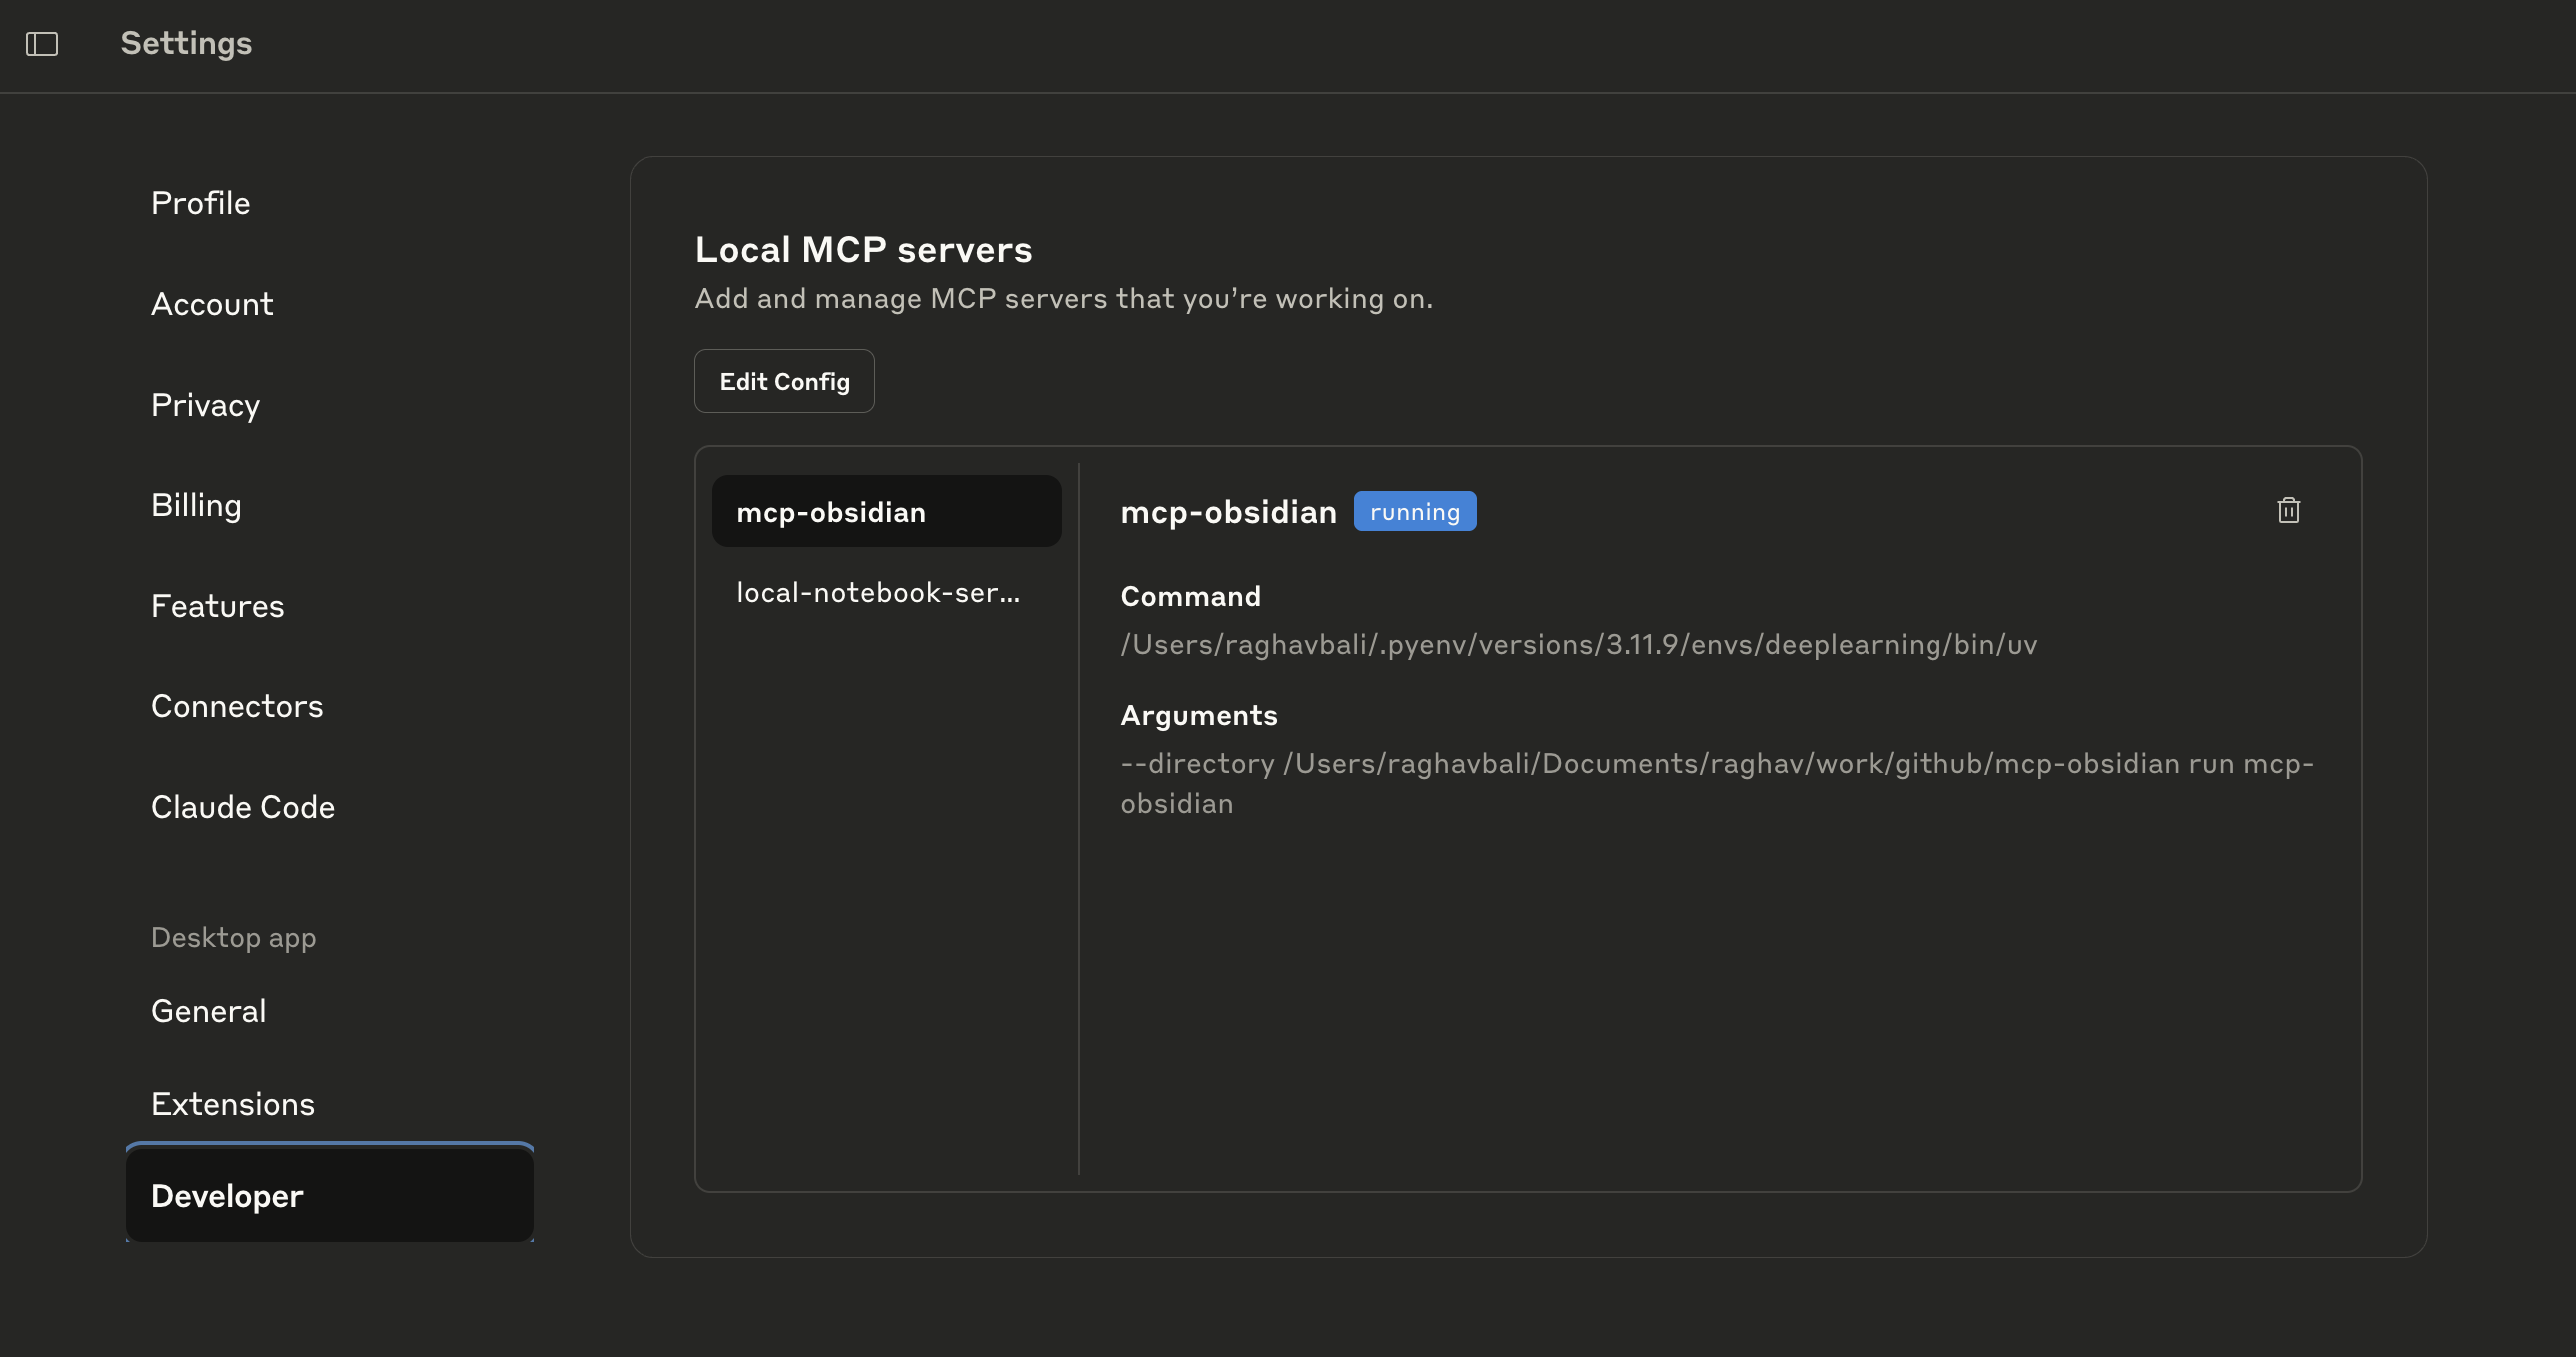

#### Edit Config
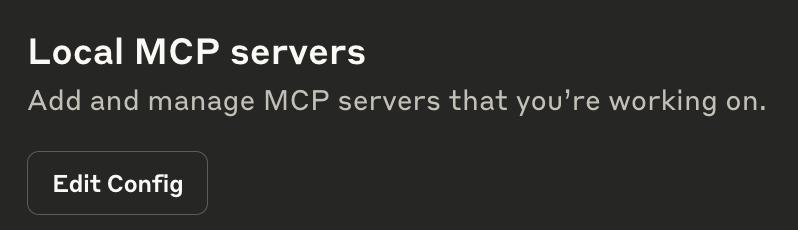

#### Open the Config File
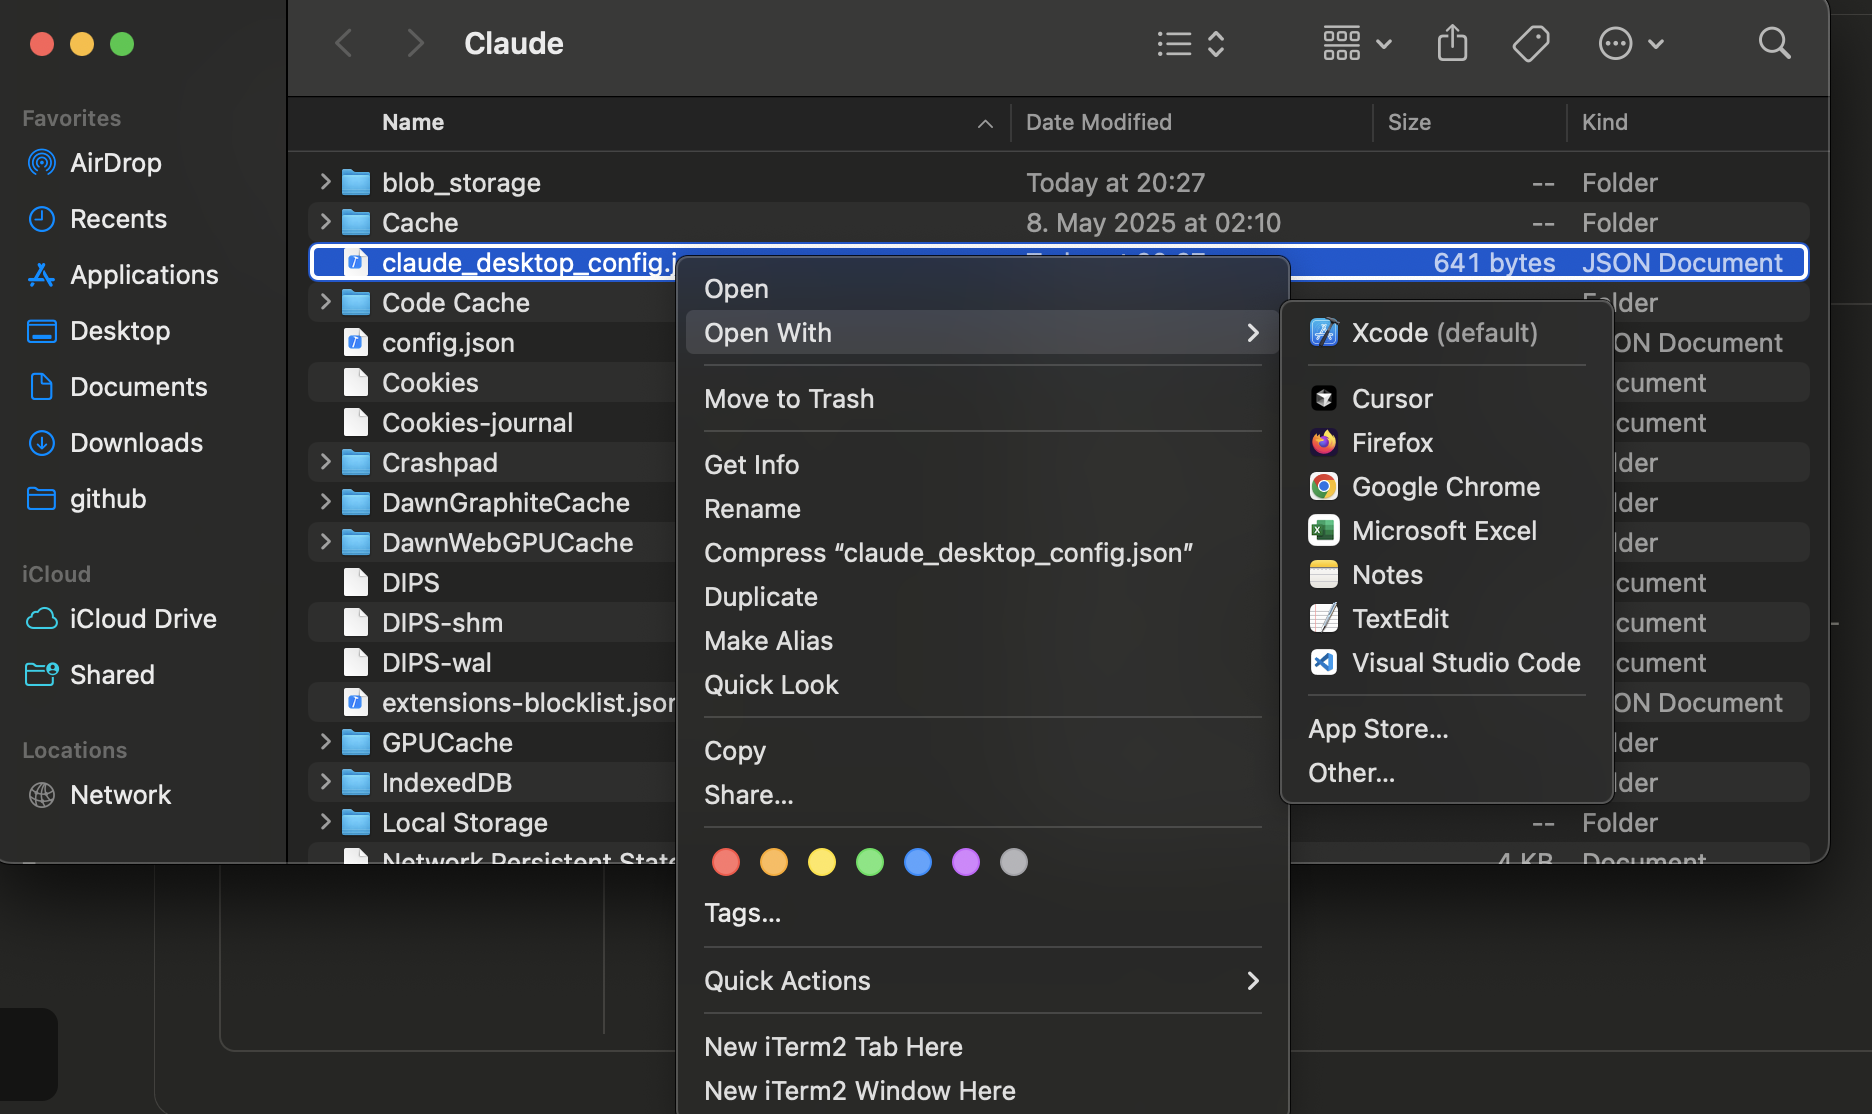

#### Add Notebook Server
```python
{
  "mcpServers": {
    "local-notebook-server": {
      "command": "<path to your python env>/python3",
      "args": [
        "<path to notebook server>/notebook_server.py"
      ]
    }
}
```

### Interacting with Notebook Server

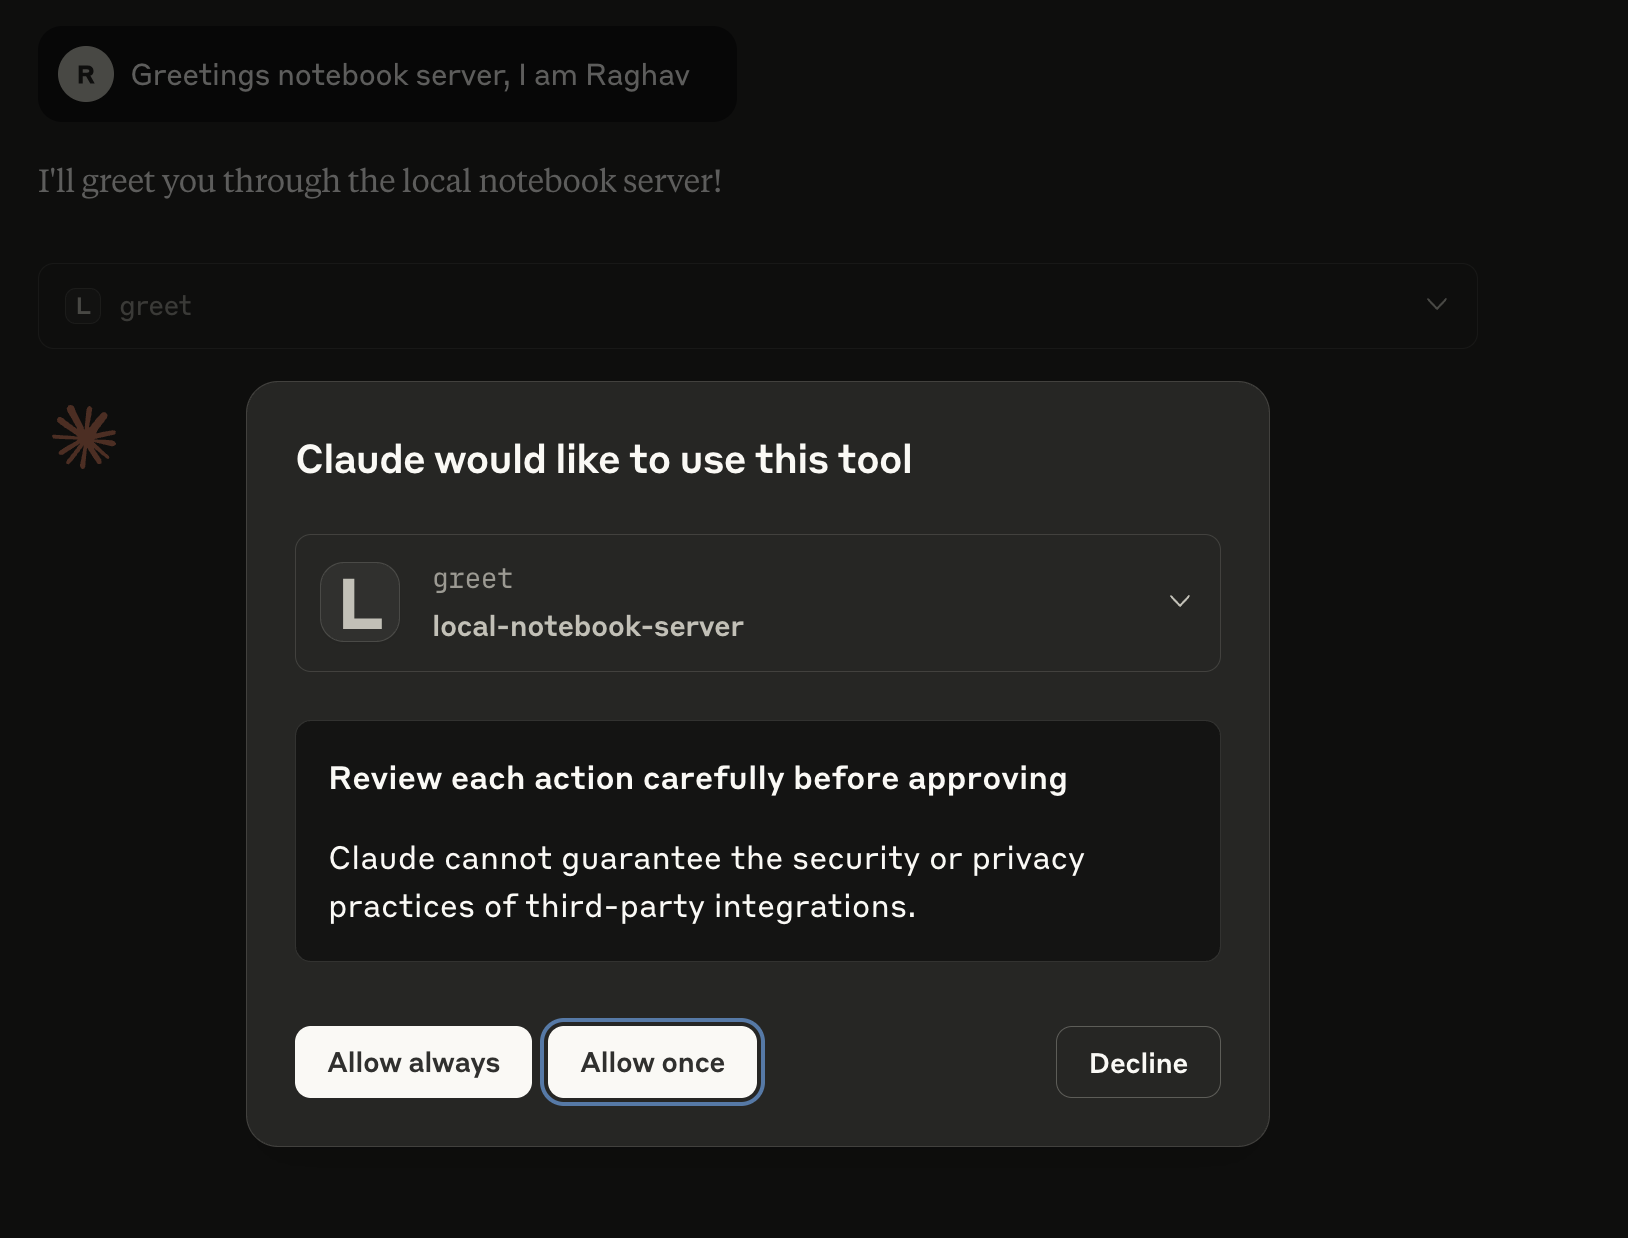

## Scrape Notebooks

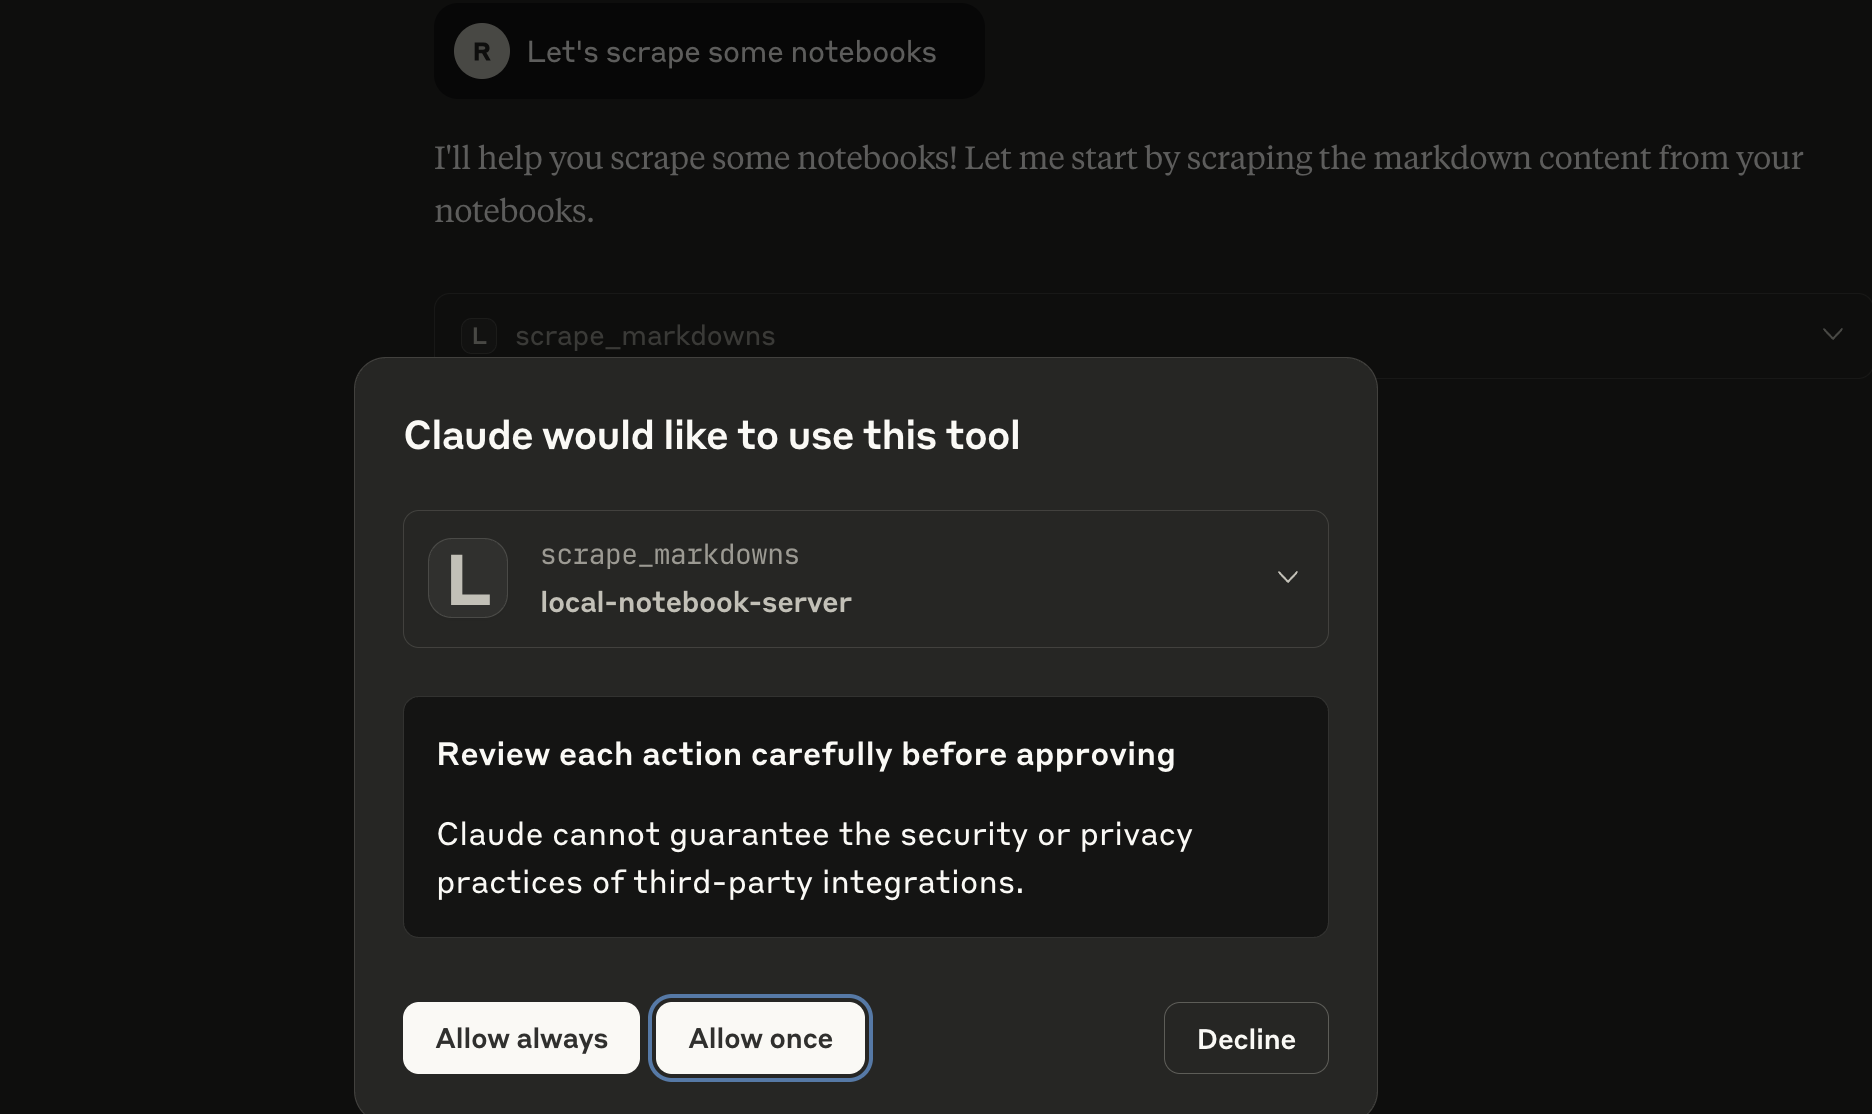

## Get List of Notebooks

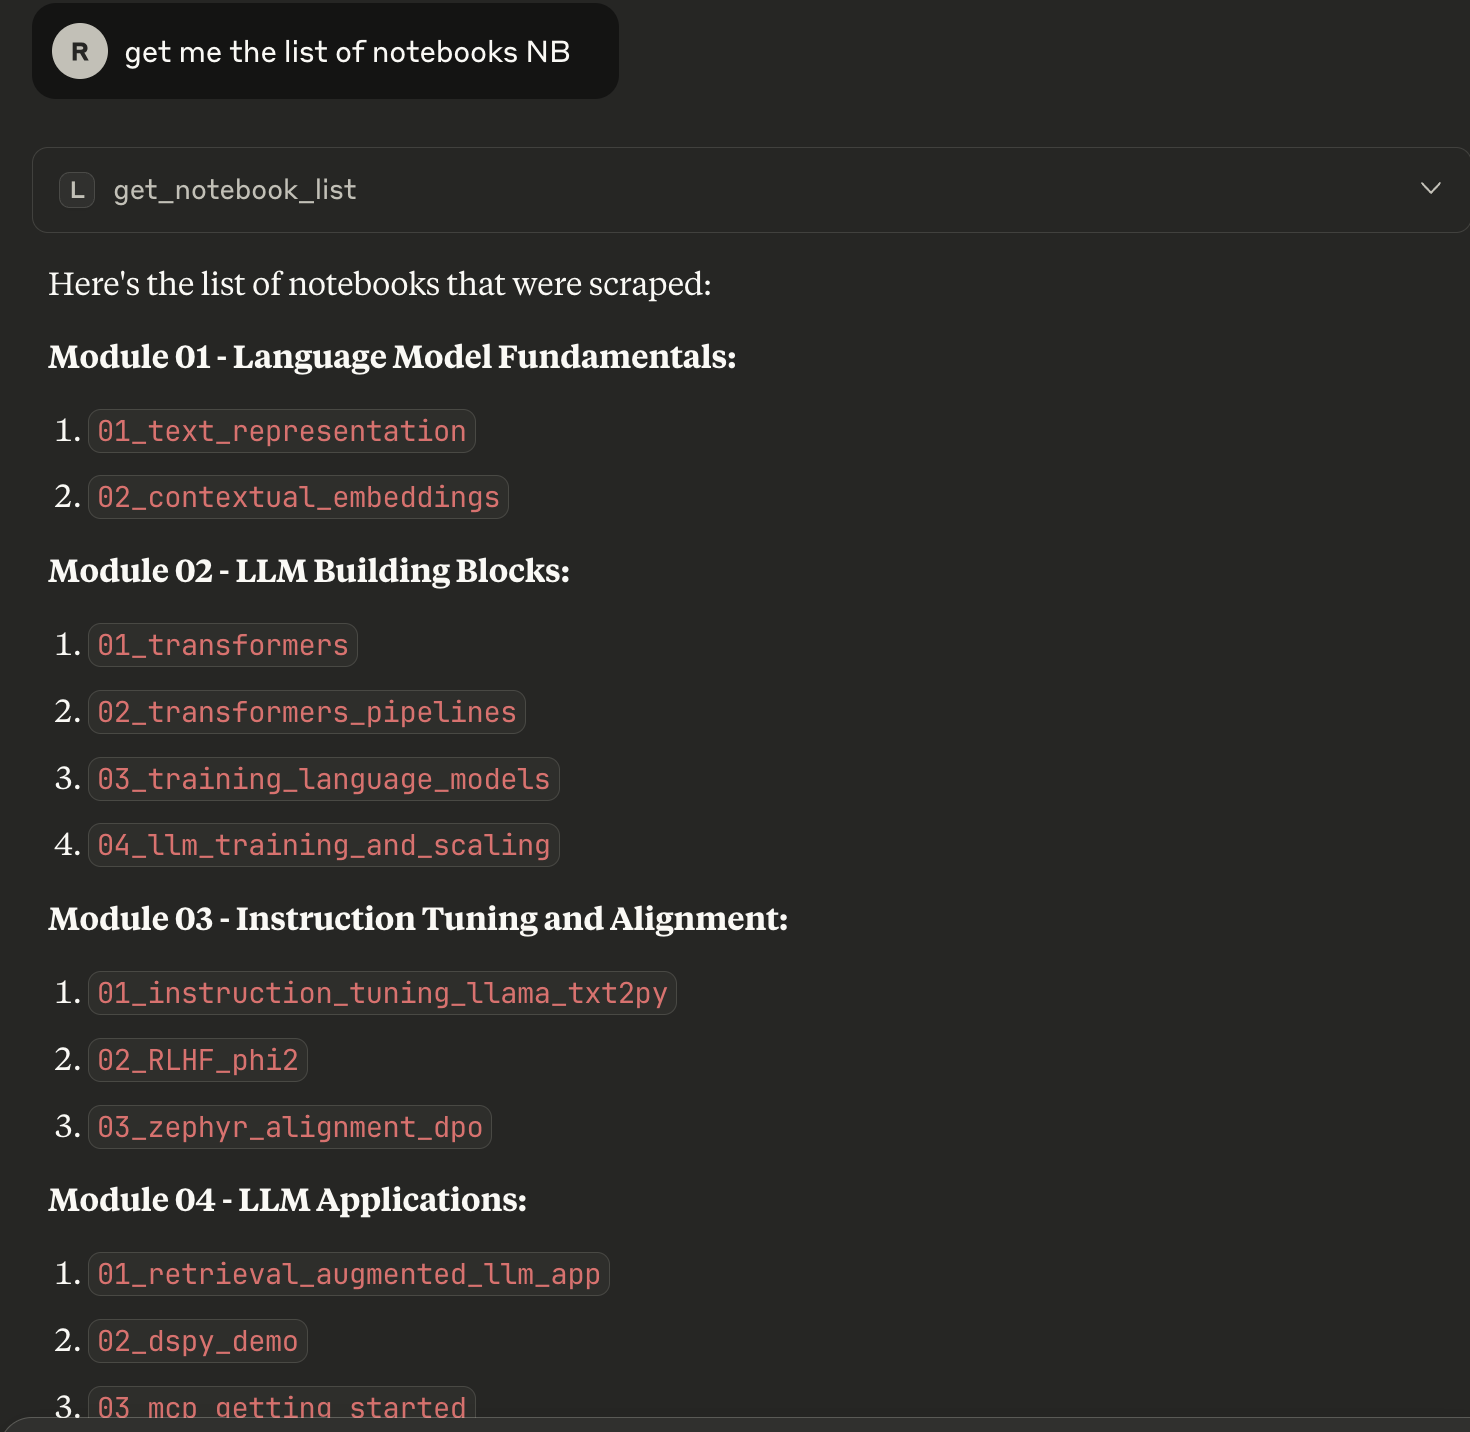